In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.patches as pch
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pdf
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

# Watermark is not required for this code, but is included for information. 
import watermark
%load_ext watermark
%watermark -a "ELEANOR LUTZ" -d -v -iv -m

pandas                          0.23.4
matplotlib.backends.backend_pdf 3.0.3
numpy                           1.15.4
cartopy                         0.17.0
matplotlib                      3.0.3
watermark                       1.8.1
ELEANOR LUTZ 2019-06-20 

CPython 3.7.1
IPython 7.2.0

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 63 Stepping 2, GenuineIntel
CPU cores  : 12
interpreter: 64bit


In [2]:
# Set figure size in inches to existing scrollwork dimensions
figsize = (40.007/2, 0.99474216554*20.24/2)
north = [0, 90]
south = [0, -90]
east = [90, 0]
west = [270, 0]

large_proj = ccrs.EckertIV()

# Assign the filenames for the data used in this map
geo_units = "./data/SIM3292_MarsGlobalGeologicGIS_20M/SIM3292_Shapefiles/SIM3292_Global_Geology.shp"
geo_contacts = "./data/SIM3292_MarsGlobalGeologicGIS_20M/SIM3292_Shapefiles/SIM3292_Global_Contacts.shp"
geo_structures = "./data/SIM3292_MarsGlobalGeologicGIS_20M/SIM3292_Shapefiles/SIM3292_Global_Structure.shp"

In [3]:
def set_save_image(fig, savename, dpi=600):
    # Output text as editable PDF text objects instead of shapes
    matplotlib.rcParams['pdf.fonttype'] = 42
    
    # Force PDF to respect zorder by supressing image compositing
    matplotlib.rcParams['image.composite_image'] = False

    # Remove borders on the plot axes
    for ax in fig.get_axes():
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        try:
            ax.set_global()
            ax.outline_patch.set_edgecolor('none')
        except:
            pass 
        
    # Remove all padding and margins
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(matplotlib.pyplot.NullLocator())
    plt.gca().yaxis.set_major_locator(matplotlib.pyplot.NullLocator())
        
    if savename.split('.')[-1] == 'pdf':
        pp = pdf.PdfPages(savename, keep_empty=False)
        pp.savefig(fig)
        pp.close()
    elif savename.split('.')[-1] == 'png':
        plt.savefig(savename, format='png', dpi=dpi, pad_inches=0, transparent=True)
    else:
        print("Unrecognized file format, plot not saved!")

    plt.show()
    plt.clf()
    plt.close('all')
    
def make_figure(ch=79):
    # Make each subplot in the exact size that fits into the scrollwork border
    # The variable ch is the distance of each small minimap from the edge of the plot 
    # (I moved this around a bit while experimenting with the design)
    
    fig = plt.figure(figsize=figsize)
    grid = matplotlib.gridspec.GridSpec(6040, 12002)
    ax = fig.add_subplot(grid[40:6000, 40:12002-40], projection=large_proj)
    ax1 = fig.add_subplot(grid[ch:852+ch, ch:852+ch], projection=ccrs.Orthographic(*north))
    ax2 = fig.add_subplot(grid[ch:852+ch, 12002-(852+ch):12002-ch], projection=ccrs.Orthographic(*south))
    ax3 = fig.add_subplot(grid[6040-(852+ch):6040-ch, ch:852+ch], projection=ccrs.Orthographic(*east))
    ax4 = fig.add_subplot(grid[6040-(852+ch):6040-ch, 12002-(852+ch):12002-ch], projection=ccrs.Orthographic(*west))
    
    return fig, ax, ax1, ax2, ax3, ax4

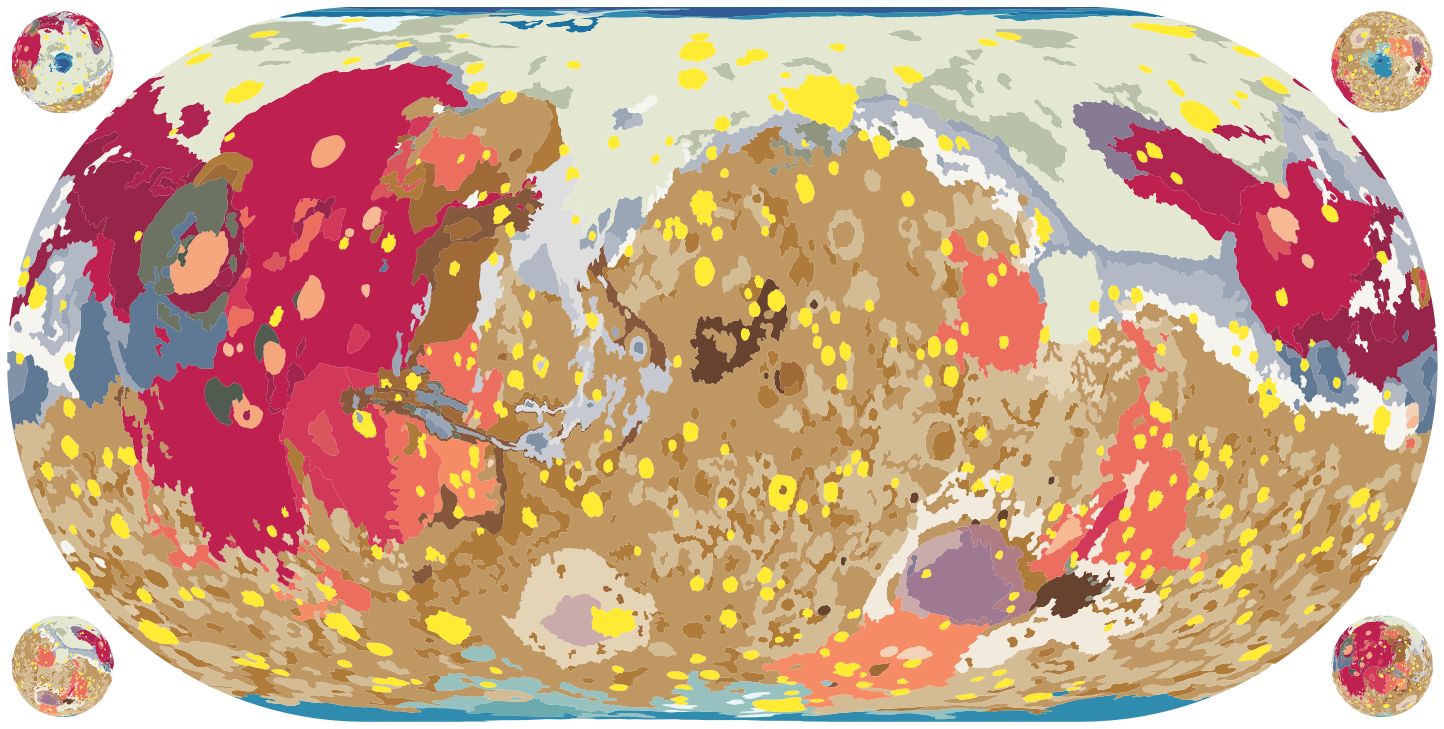

In [4]:
# Plot geologic units
savename = './figures/geologic_units.png'

shp = shpreader.Reader(geo_units)
df = pd.read_csv('./data/Mars_geologic_units.csv', header=0, index_col='name')

fig, ax, ax1, ax2, ax3, ax4 = make_figure()
for record, state in zip(shp.records(), shp.geometries()):
    name = record.attributes['Unit'].upper() # don't want to deal with case differences
    facecolor = df.loc[name]['color']
    if name not in df.index.tolist():
        print(name) # check for misspellings or missing values
    for a in [ax, ax1, ax2, ax3, ax4]:
        a.add_geometries([state], ccrs.PlateCarree(), facecolor=facecolor)

set_save_image(fig, savename)

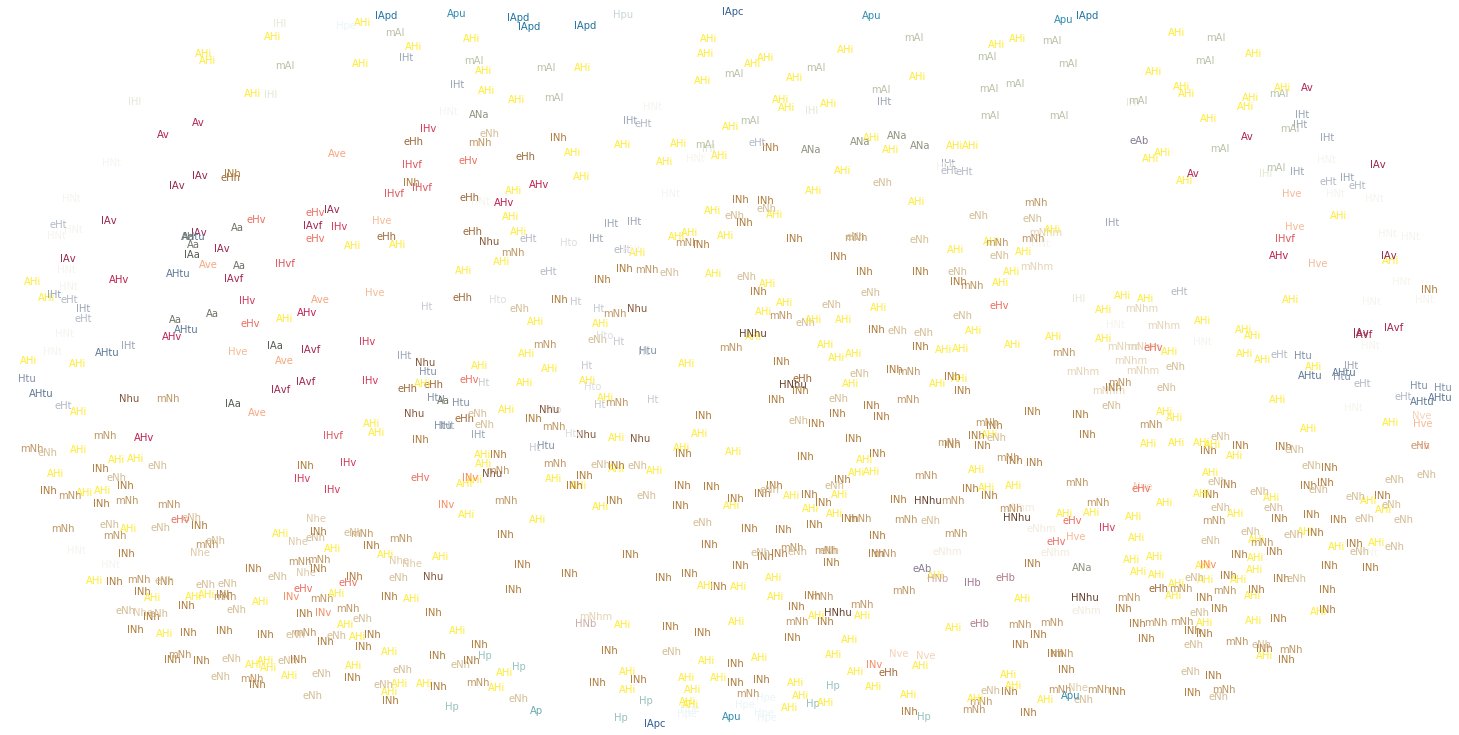

In [5]:
# Geologic labels
# (Not included in the minimaps because they are too small for legible labels) 

savename = './figures/geologic_unit_labels.pdf'
shp = shpreader.Reader(geo_units)
df = pd.read_csv('./data/Mars_geologic_units.csv', header=0, index_col='name')
fig, ax, ax1, ax2, ax3, ax4 = make_figure()

for record, state in zip(shp.records(), shp.geometries()):
    name = record.attributes['Unit'].upper() # don't want to deal with case differences
    facecolor = df.loc[name]['color']
    if name not in df.index.tolist():
        print(name) # check for misspellings or missing values
    if record.attributes['Shape_Area'] > 10000000000:
        xmin, ymin, xmax, ymax = state.bounds
        plotx, ploty = xmin+(xmax-xmin)/2, ymin+(ymax-ymin)/2
        ax.text(plotx, ploty, record.attributes['Unit'], transform=ccrs.PlateCarree(),  
                ha='left', va='center', color=facecolor, zorder=100)

set_save_image(fig, savename)

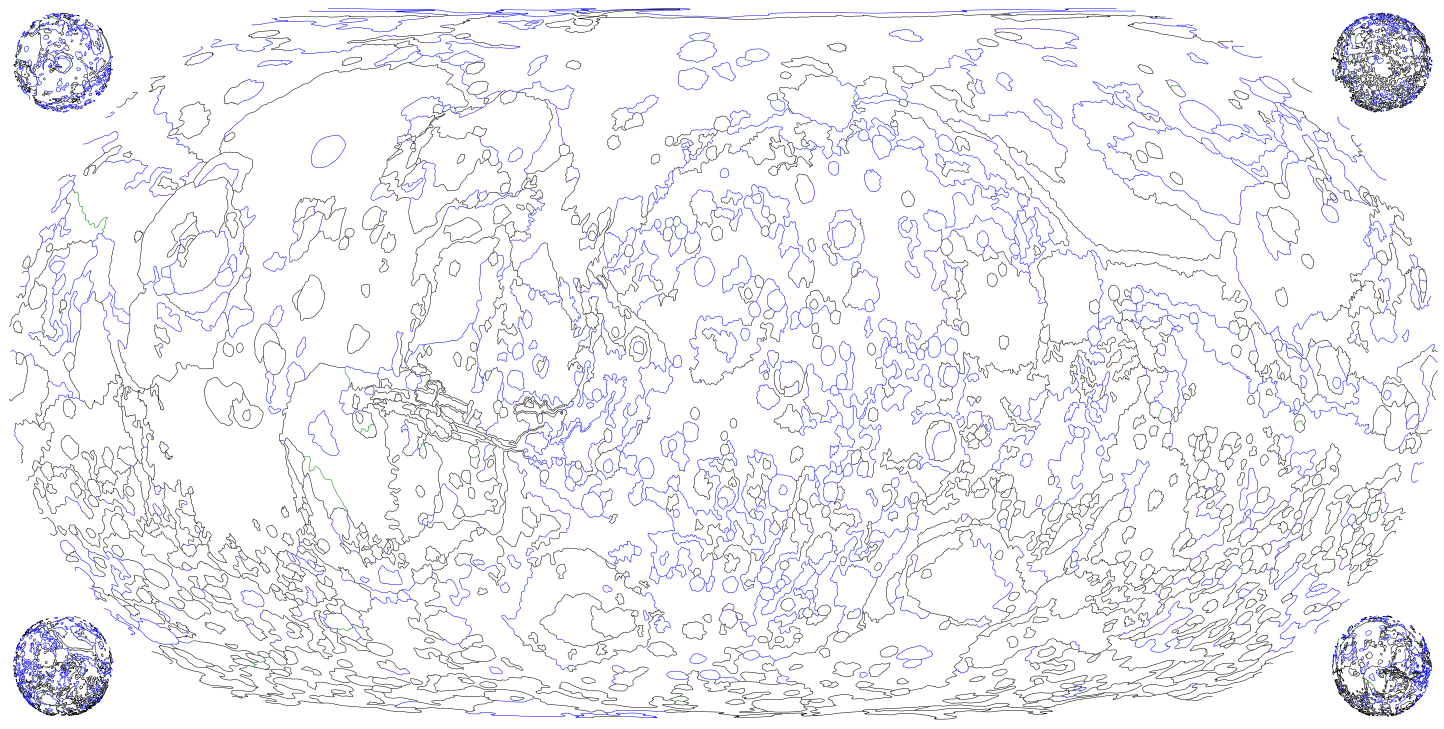

In [6]:
# Plot geologic contacts
savename = './figures/contacts.pdf'
shp = shpreader.Reader(geo_contacts)
fig, ax, ax1, ax2, ax3, ax4 = make_figure()
df = pd.read_csv('./data/Mars_geologic_boundaries.csv', index_col='type')

for record, state in zip(shp.records(), shp.geometries()):
    c = df.loc[record.attributes['ConType']]['color']
    for a in [ax, ax1, ax2, ax3, ax4]:
        a.add_geometries([state], ccrs.PlateCarree(), facecolor='none', edgecolor=c, lw=0.5)

set_save_image(fig, savename)

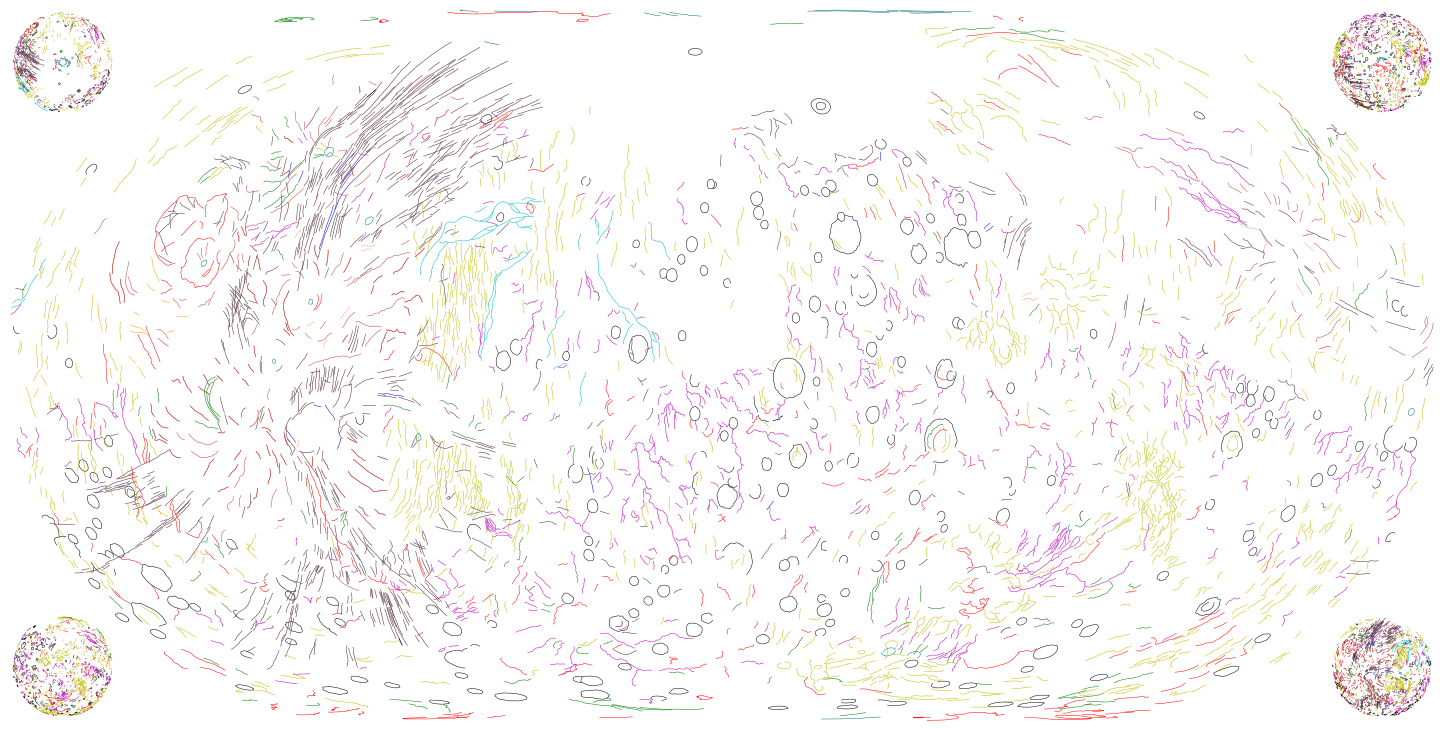

In [7]:
# Plot geologic structures 
savename = './figures/structures.pdf'
shp = shpreader.Reader(geo_structures)
fig, ax, ax1, ax2, ax3, ax4 = make_figure()
df = pd.read_csv('./data/Mars_geologic_boundaries.csv', index_col='type')

for record, state in zip(shp.records(), shp.geometries()):
    c = df.loc[record.attributes['Interpreta']]['color']
    for a in [ax, ax1, ax2, ax3, ax4]:
        a.add_geometries([state], ccrs.PlateCarree(), facecolor='none', edgecolor=c, lw=0.5)

set_save_image(fig, savename)

In [8]:
# Assign a random color to each type of landscape feature and save it to a file
features = pd.read_csv('./data/mars_features.csv')
fset = features.groupby('Feature_Type_Code').count().sort_values(by='Feature_ID', ascending=False)

features = features.drop_duplicates(subset=['Feature_Type_Code'], keep="first")
features = features[['Feature_Type_Code', 'Feature_Type']]
features.sort_values(by="Feature_Type_Code", inplace=True)
features['Feature_Type_Code'] = features['Feature_Type_Code'].str.strip()

chars = [x for x in '0123456789ABCDEF']
colors = ['#'+''.join(np.random.choice(chars, size=6)) for i in range(len(features))]
features['color'] = colors
features.to_csv('./data/feature_colors.csv', index=False)

0 duplicate values dropped from dataset


Feature_Type_Code,AA,VA,FO,MO,MN,DO,PM,RU,CH,CM,...,TH,LB,UN,LN,PA,LA,FL,AL,SE,VS
Feature_ID,275,120,57,40,33,32,30,26,24,21,...,8,6,6,5,5,4,2,1,1,1


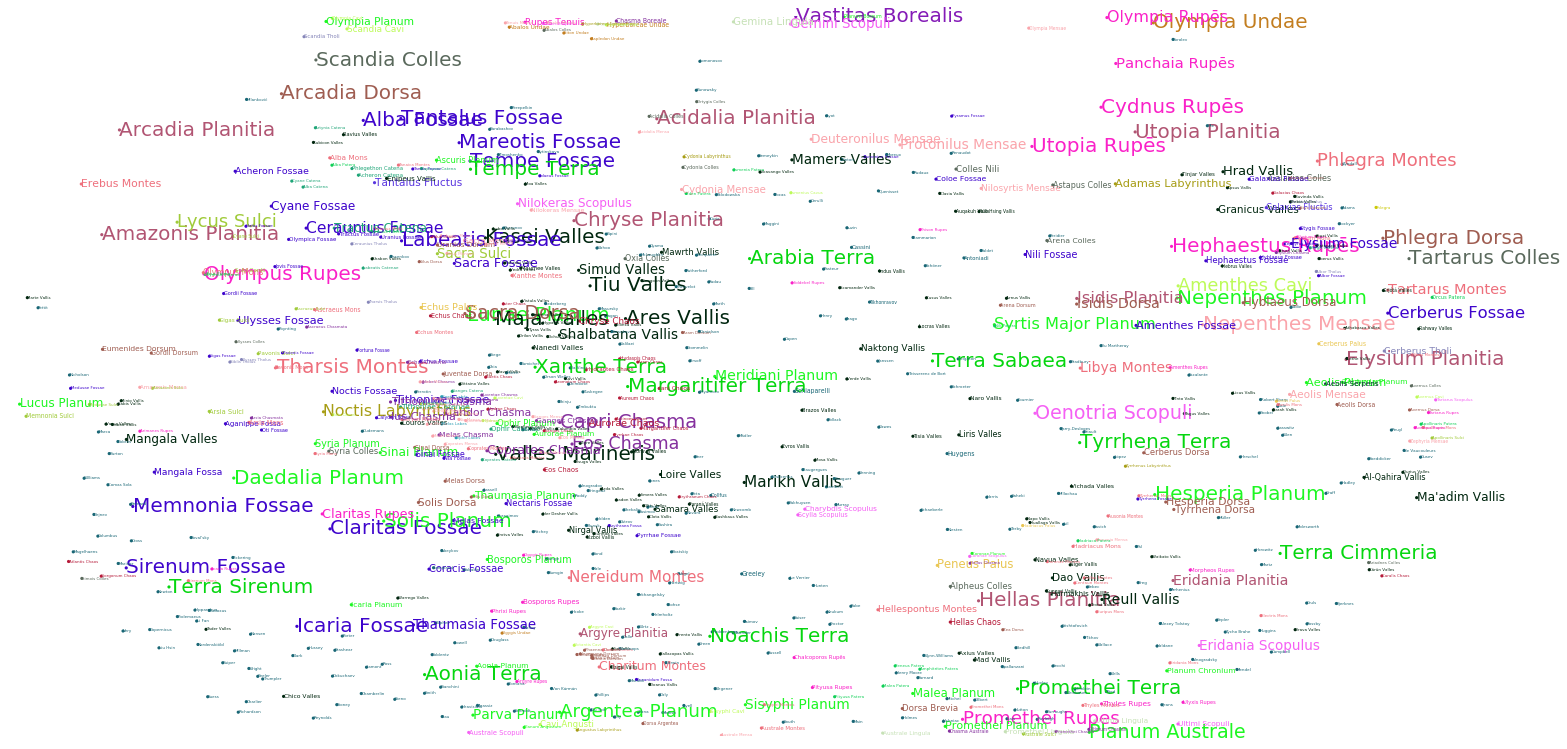

In [9]:
# Plot each of the landscape features in the color assigned in the previous cell
# (Labels not included in the minimaps because they are too small for legible labels)

savename = './figures/features.pdf'

features = pd.read_csv('./data/mars_features.csv')
check = len(features)
features = features.drop_duplicates(subset=['Feature_ID'])
print(check - len(features), "duplicate values dropped from dataset")

fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=large_proj)  
ax.set_global()

colors = pd.read_csv('./data/feature_colors.csv', index_col='Feature_Type_Code')
features.sort_values(by=["Diameter"], inplace=True, ascending=False)
features = features.head(min(800, len(features)))
for index, row in features.iterrows():
    text = row['Feature_Name']
    x, y, s = row['Center_Longitude'], row['Center_Latitude'], row['Diameter']
    c = colors.loc[row['Feature_Type_Code'].strip()]['color']
    ax.text(x, y, text, transform=ccrs.PlateCarree(), 
            ha='left', va='center', fontsize=min(max(4, s/75), 20), color=c)
    ax.scatter(x, y, transform=ccrs.PlateCarree(), s=10, color=c, edgecolor='None', lw=0)
    
fset = features.groupby('Feature_Type_Code').count().sort_values(by='Feature_ID', 
         ascending=False)[['Feature_ID']].transpose()
display(fset)

set_save_image(fig, savename)

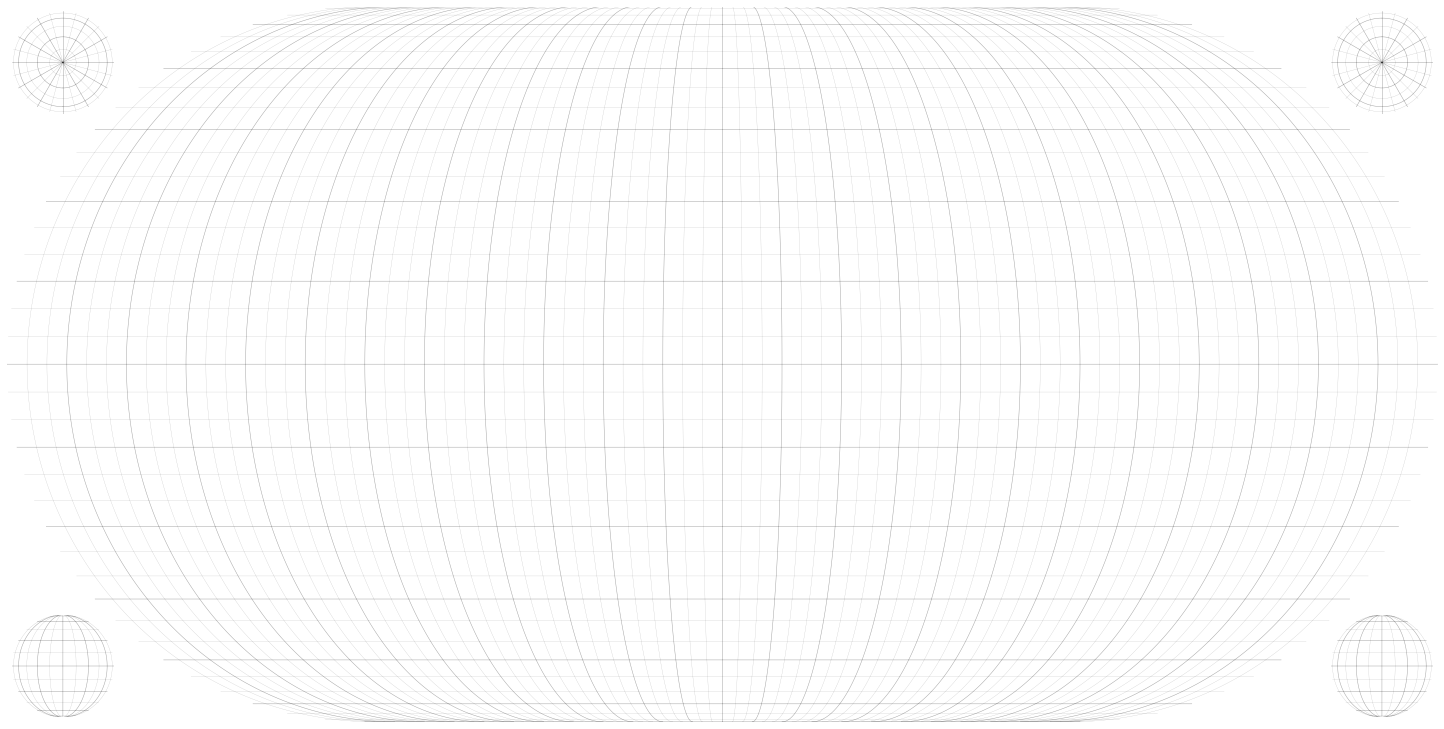

In [10]:
savename = './figures/gridlines.png'

fig, ax, ax1, ax2, ax3, ax4 = make_figure()
lon_large = np.arange(0, 360, 30)
lon_small = np.arange(0, 360, 15)
lon_mini = np.arange(0, 360, 5)
lat_large = np.arange(-90, 91, 30)
lat_small = np.arange(-90, 91, 15)
lat_mini = np.arange(-90, 91, 5)
lat_delim = np.arange(-90, 90.01, 0.1)
lon_delim = np.arange(0, 360, 0.1)

for a in [ax1, ax2, ax3, ax4]:
    for lg in lat_large: 
        a.plot(lon_delim, [lg]*len(lon_delim), transform=ccrs.PlateCarree(), color='k', lw=0.5, alpha=0.35)
    for sm in lat_small: 
        if sm not in lat_large: 
            a.plot(lon_delim, [sm]*len(lon_delim), transform=ccrs.PlateCarree(), color='k', lw=0.25, alpha=0.25)
    for lg in lon_large: 
        a.plot([lg]*len(lat_delim), lat_delim, transform=ccrs.PlateCarree(), color='k', lw=0.5, alpha=0.35)
    for sm in lon_small: 
        if sm not in lon_large: 
            a.plot([sm]*len(lat_delim), lat_delim, transform=ccrs.PlateCarree(), color='k', lw=0.25, alpha=0.25)

for lg in lat_small: 
    ax.plot(lon_delim, [lg]*len(lon_delim), transform=ccrs.PlateCarree(), color='k', lw=0.5, alpha=0.35)
for sm in lat_mini: 
    if sm not in lat_small: 
        ax.plot(lon_delim, [sm]*len(lon_delim), transform=ccrs.PlateCarree(), color='k', lw=0.25, alpha=0.25)
for lg in lon_small: 
    ax.plot([lg]*len(lat_delim), lat_delim, transform=ccrs.PlateCarree(), color='k', lw=0.5, alpha=0.35)
for sm in lon_mini: 
    if sm not in lon_small: 
        ax.plot([sm]*len(lat_delim), lat_delim, transform=ccrs.PlateCarree(), color='k', lw=0.25, alpha=0.25)

set_save_image(fig, savename)

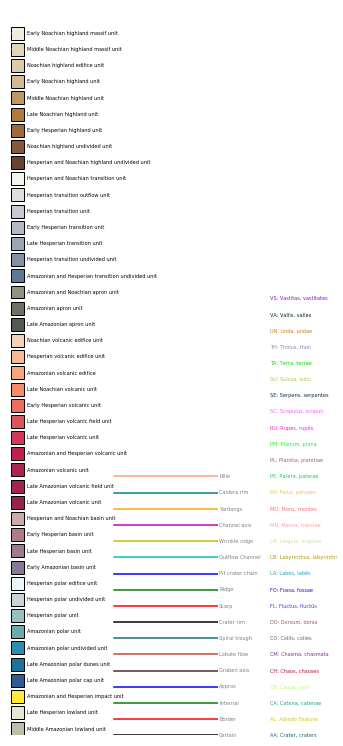

In [11]:
# Display names of each geologic unit or structure alongisde assigned color
# (for reference only, so this plot is not very pretty)

savename = './figures/key.pdf'

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_aspect("equal")
match = 1.25

# Plot key for colors
df = pd.read_csv('./data/Mars_geologic_units.csv')
for ii, (index, row) in enumerate(df.iterrows()): 
    ax.add_patch(pch.Rectangle((0, match*ii), width=1, height=1, 
                               facecolor=row['color'], edgecolor='k'))
    ax.text(0.5, match*ii+0.5, row['name_actual'], ha='center', va='center', 
            color=row['color'], fontsize=5, alpha=0.5)
    ax.text(1.25, match*ii+0.5, row['description'],
            alpha=1, fontsize=5, ha='left', va='center')
ax.set_ylim(0, match*len(df)+1)    

# Plot key for boundaries
df = pd.read_csv('./data/Mars_geologic_boundaries.csv')
for ii, (index, row) in enumerate(df.iterrows()): 
    ax.plot([8, 16], [match*ii, match*ii], color=row['color'])
    ax.text(16.1, match*ii, row['type'], ha='left', va='center', fontsize=5, alpha=0.5)

# Plot key for labels
df = pd.read_csv('./data/feature_colors.csv')
for ii, (index, row) in enumerate(df.iterrows()): 
    ax.text(20, match*ii, row['Feature_Type_Code']+": "+row['Feature_Type'], 
            ha='left', va='center', fontsize=5, color=row['color'])

set_save_image(fig, savename)